# 8.3 Language Models and the Dataset
In Section 8.2, we see how to map text data into tokens, where these tokens can be viewed as a
sequence of discrete observations, such as words or characters. Assume that the tokens in a text
sequence of length $T$ are in turn $x_1, x_2, . . . , x_T$ . Then, in the text sequence, $x_t(1 ≤ t ≤ T)$ can
be considered as the observation or label at time step $t$. Given such a text sequence, the goal of a
*language model* is to estimate the joint probability of the sequence

$$P(x_1, x_2, . . . , x_T ). (8.3.1)$$

Language models are incredibly useful. For instance, an ideal language model would be able
to generate natural text just on its own, simply by drawing one token at a time $x_t ∼ P(x_t|x_{t−1}, . . . , x_1)$. Quite unlike the monkey using a typewriter, all text emerging from such a model
would pass as natural language, e.g., English text. Furthermore, it would be sufficient for generating a meaningful dialog, simply by conditioning the text on previous dialog fragments. Clearly
we are still very far from designing such a system, since it would need to understand the text rather
than just generate grammatically sensible content.
Nonetheless, language models are of great service even in their limited form. For instance, the
phrases “to recognize speech” and “to wreck a nice beach” sound very similar. This can cause ambiguity in speech recognition, which is easily resolved through a language model that rejects the
second translation as outlandish. Likewise, in a document summarization algorithm it is worthwhile knowing that “dog bites man” is much more frequent than “man bites dog”, or that “I want
to eat grandma” is a rather disturbing statement, whereas “I want to eat, grandma” is much more
benign.

## 8.3.1 Learning a Language Model
The obvious question is how we should model a document, or even a sequence of tokens. Suppose
that we tokenize text data at the word level. We can take recourse to the analysis we applied to
sequence models in Section 8.1. Let us start by applying basic probability rules:

$$P(x_1, x_2, . . . , x_T ) = \prod_{t=1}^T P(x_t | x_1, . . . , x_{t−1}). (8.3.2)$$

For example, the probability of a text sequence containing four words would be given as:

$$P(deep, learning, is,fun) = P(deep)P(learning | deep)P(is | deep, learning)P(fun | deep, learning, is).
(8.3.3)$$

In order to compute the language model, we need to calculate the probability of words and the
conditional probability of a word given the previous few words. Such probabilities are essentially
language model parameters.
Here, we assume that the training dataset is a large text corpus, such as all Wikipedia entries,
Project Gutenberg103, and all text posted on the Web. The probability of words can be calculated
from the relative word frequency of a given word in the training dataset. For example, the estimate
$\hat{P}(deep)$ can be calculated as the probability of any sentence starting with the word “deep”. A
slightly less accurate approach would be to count all occurrences of the word “deep” and divide it by the total number of words in the corpus. This works fairly well, particularly for frequent words.
Moving on, we could attempt to estimate

$$\hat{P}(learning | deep) = \frac{n(deep, learning)}{ n(deep)}, (8.3.4)$$

where $n(x)$ and $n(x, x')$ are the number of occurrences of singletons and consecutive word pairs,
respectively. Unfortunately, estimating the probability of a word pair is somewhat more difficult,
since the occurrences of “deep learning” are a lot less frequent. In particular, for some unusual
word combinations it may be tricky to find enough occurrences to get accurate estimates. Things
take a turn for the worse for three-word combinations and beyond. There will be many plausible three-word combinations that we likely will not see in our dataset. Unless we provide some
solution to assign such word combinations nonzero count, we will not be able to use them in a
language model. If the dataset is small or if the words are very rare, we might not find even a
single one of them.
A common strategy is to perform some form of Laplace smoothing. The solution is to add a small
constant to all counts. Denote by n the total number of words in the training set and m the number
of unique words. This solution helps with singletons, e.g., via

$$\hat{P}(x) = \frac{n(x) + ϵ_1/m}{n + ϵ_1},$$

$$\hat{P}(x' | x) = \frac{n(x, x') + ϵ_2\hat{P}(x')}{n(x) + ϵ_2},$$

$$\hat{P}(x' | x, x') = \frac{n(x, x', x') + ϵ_3\hat{P}(x')} {n(x, x') + ϵ_3}$$

Here $ϵ_1, ϵ_2, and ϵ_3$ are hyperparameters. Take $ϵ_1$ as an example: when $ϵ_1 = 0$, no smoothing is
applied; when $ϵ_1$ approaches positive infinity, $\hat{P}(x)$ approaches the uniform probability $1/m$. The
above is a rather primitive variant of what other techniques can accomplish (Wood et al., 2011).
Unfortunately, models like this get unwieldy rather quickly for the following reasons. First, we
need to store all counts. Second, this entirely ignores the meaning of the words. For instance,
“cat” and “feline” should occur in related contexts. It is quite difficult to adjust such models to
additional contexts, whereas, deep learning based language models are well suited to take this
into account. Last, long word sequences are almost certain to be novel, hence a model that simply
counts the frequency of previously seen word sequences is bound to perform poorly there.

## 8.3.2 Markov Models and n-grams
Before we discuss solutions involving deep learning, we need some more terminology and concepts. Recall our discussion of Markov Models in Section 8.1. Let us apply this to language
modeling. A distribution over sequences satisfies the Markov property of first order if $P(x_{t+1} | x_t , . . . , x_1) = P(x_{t+1} | x_t)$. Higher orders correspond to longer dependencies. This leads to a
number of approximations that we could apply to model a sequence:
$$P(x_1, x_2, x_3, x_4) = P(x_1)P(x_2)P(x_3)P(x_4),$$
$$P(x_1, x_2, x_3, x_4) = P(x_1)P(x_2 | x_1)P(x_3 | x_2)P(x_4 | x_3),$$
$$P(x_1, x_2, x_3, x_4) = P(x_1)P(x_2 | x_1)P(x_3 | x_1, x_2)P(x_4 | x_2, x_3).$$
$$(8.3.6)$$
The probability formulae that involve one, two, and three variables are typically referred to as
unigram, bigram, and trigram models, respectively. In the following, we will learn how to design
better models.

## 8.3.3 Natural Language Statistics
Let us see how this works on real data. We construct a vocabulary based on the time machine
dataset as introduced in Section 8.2 and print the top 10 most frequent words.

In [1]:
use strict;
use warnings;
use Data::Dump qw(dump);
use AI::MXNet qw(mx);
use List::Util qw(min max shuffle zip);
use d2l;
use d2l::Vocab;

In [2]:
my $tokens = d2l->tokenize(d2l->read_time_machine());
# Since each text line is not necessarily a sentence or a paragraph, we
# concatenate all text lines
my @corpus = map{ map{ [$_] } @$_ } @$tokens;
my $vocab = Vocab->new([@corpus]);
print dump @{$vocab->{_token_freqs}}[0 .. 9]

(
  ["the", 2477],
  ["and", 1312],
  ["of", 1286],
  ["i", 1268],
  ["a", 877],
  ["to", 766],
  ["in", 606],
  ["was", 554],
  ["that", 458],
  ["it", 452],
)

1

As we can see, the most popular words are actually quite boring to look at. They are often referred
to as stop words and thus filtered out. Nonetheless, they still carry meaning and we will still use
them. Besides, it is quite clear that the word frequency decays rather rapidly. The $10^{th}$ most frequent word is less than 1/5 as common as the most popular one. To get a better idea, we plot the
figure of the word frequency

In [3]:
my @freqs = ();
for (@{$vocab->{_token_freqs}}){
    push(@freqs, $_->[1])
}

my @keys = keys( @freqs);
d2l->plot([[@keys]], [[@freqs]], xlabel=>'token: x', ylabel=>'frequency: n(x)', xscale=>'log',yscale=>'log');


We are on to something quite fundamental here: the word frequency decays rapidly in a welldefined way. After dealing with the first few words as exceptions, all the remaining words roughly
follow a straight line on a log-log plot. This means that words satisfy Zipf’s law, which states that
the frequency ni of the $i^{th}$ most frequent word is:

$$n_i ∝\frac{1}{i^α}, (8.3.7)$$

which is equivalent to
$$log(n_i) = −α * log(i) + c, (8.3.8)$$

where α is the exponent that characterizes the distribution and c is a constant. This should already
give us pause if we want to model words by count statistics and smoothing. After all, we will
significantly overestimate the frequency of the tail, also known as the infrequent words. But what
about the other word combinations, such as bigrams, trigrams, and beyond? Let us see whether
the bigram frequency behaves in the same manner as the unigram frequency.

In [4]:
my @bigram_tokens = ();
my $len = @corpus;
for (keys @corpus){
    if($_ > 0){
        push(@bigram_tokens, ["$corpus[$_-1][0] $corpus[$_][0]"]);
    }
}
my $bigram_vocab = Vocab->new([@bigram_tokens]);
print dump @{$bigram_vocab->{_token_freqs}}[0 .. 9];

(
  ["of the", 344],
  ["in the", 192],
  ["i had", 130],
  ["and the", 112],
  ["i was", 112],
  ["the time", 110],
  ["to the", 101],
  ["it was", 99],
  ["project gutenberg", 88],
  ["as i", 78],
)

1

One thing is notable here. Out of the ten most frequent word pairs, nine are composed of both stop
words and only one is relevant to the actual book—“the time”. Furthermore, let us see whether the
trigram frequency behaves in the same manner

In [5]:
my @trigram_tokens = ();
my $len = @corpus;
for (keys @corpus){
    if($_ > 1){
        push(@trigram_tokens, ["$corpus[$_-2][0] $corpus[$_-1][0] $corpus[$_][0]"]);
    }
}
my $trigram_vocab = Vocab->new([@trigram_tokens]);
print dump @{$trigram_vocab->{_token_freqs}}[0 .. 9];

(
  ["the time traveller", 63],
  ["project gutenberg tm", 57],
  ["the time machine", 34],
  ["the project gutenberg", 33],
  ["the medical man", 24],
  ["gutenberg tm electronic", 18],
  ["it seemed to", 16],
  ["here and there", 15],
  ["it was a", 15],
  ["i did not", 14],
)

1

Last, let us visualize the token frequency among these three models: unigrams, bigrams, and
trigrams.

In [6]:
my @bigram_freqs = ();
for (@{$bigram_vocab->{_token_freqs}}){
    push(@bigram_freqs, $_->[1])
}

my @trigram_freqs = ();
for (@{$trigram_vocab->{_token_freqs}}){
    push(@trigram_freqs, $_->[1])
}

d2l->plot([[keys @freqs], [keys @bigram_freqs], [keys @trigram_freqs]], [[@freqs], [@bigram_freqs], [@trigram_freqs]], xlabel=>'token: x',ylabel=>'frequency: n(x)', xscale=>'log', yscale=>'log',legend=>['unigram', 'bigram', 'trigram'], fmts => ['o', '-', '--'])

This figure is quite exciting for a number of reasons. First, beyond unigram words, sequences of
words also appear to be following Zipfʼs law, albeit with a smaller exponent α in (8.3.7), depending
on the sequence length. Second, the number of distinct n-grams is not that large. This gives us
hope that there is quite a lot of structure in language. Third, many n-grams occur very rarely,
which makes Laplace smoothing rather unsuitable for language modeling. Instead, we will use
deep learning based models.

## 8.3.4 Reading Long Sequence Data
Since sequence data are by their very nature sequential, we need to address the issue of processing it. We did so in a rather ad-hoc manner in Section 8.1. When sequences get too long to be
processed by models all at once, we may wish to split such sequences for reading. Now let us describe general strategies. Before introducing the model, let us assume that we will use a neural
network to train a language model, where the network processes a minibatch of sequences with
predefined length, say n time steps, at a time. Now the question is how to read minibatches of
features and labels at random.
To begin with, since a text sequence can be arbitrarily long, such as the entire The Time Machine
book, we can partition such a long sequence into subsequences with the same number of time
steps. When training our neural network, a minibatch of such subsequences will be fed into the
model. Suppose that the network processes a subsequence of n time steps at a time. Fig. 8.3.1
shows all the different ways to obtain subsequences from an original text sequence, where n = 5
and a token at each time step corresponds to a character. Note that we have quite some freedom
since we could pick an arbitrary offset that indicates the initial position.

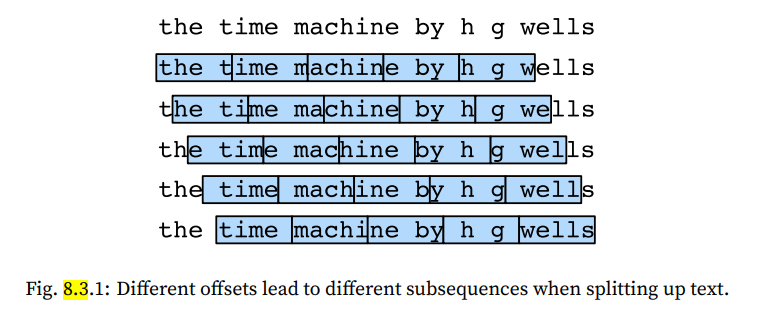

Hence, which one should we pick from Fig. 8.3.1? In fact, all of them are equally good. However, if
we pick just one offset, there is limited coverage of all the possible subsequences for training our
network. Therefore, we can start with a random offset to partition a sequence to get both coverage
and randomness. In the following, we describe how to accomplish this for both random sampling
and sequential partitioning strategies.

### Random Sampling
In random sampling, each example is a subsequence arbitrarily captured on the original long
sequence. The subsequences from two adjacent random minibatches during iteration are not
necessarily adjacent on the original sequence. For language modeling, the target is to predict the
next token based on what tokens we have seen so far, hence the labels are the original sequence,
shifted by one token.
The following code randomly generates a minibatch from the data each time. Here, the argument
batch_size specifies the number of subsequence examples in each minibatch and num_steps is
the predefined number of time steps in each subsequence.

In [7]:
package SEQDATA{
    use strict;
    use warnings;
    use Data::Dump qw(dump);
    use AI::MXNet qw(mx);
    use List::Util qw(min max shuffle zip);
    use d2l;
    use d2l::Vocab;
    use Exporter 'import';
    our @EXPORT_OK = qw(seq_data_iter_random seq_data_iter_sequential);  # symbols to export on request
    
    sub seq_data_iter_random{ #@save
        #"""Generate a minibatch of subsequences using random sampling."""
        my ($corpus, $batch_size, $num_steps) = @_;
        
        # Start with a random offset (inclusive of `num_steps - 1`) to partition a
        # sequence}
        my $len = @{$corpus};
        my @corpus = @{$corpus}[int(rand($num_steps - 1)) .. $len-1];
        
        # Subtract 1 since we need to account for labels
        $len = @corpus;
        my $num_subseqs = int(($len - 1)/$num_steps);
        
        # The starting indices for subsequences of length `num_steps`
        my @initial_indices = map { $_ * $num_steps } @{[0 .. $num_subseqs-1]};

        # In random sampling, the subsequences from two adjacent random
        # minibatches during iteration are not necessarily adjacent on the
        # original sequence
        @initial_indices = shuffle @initial_indices;

        sub data{
            my ($corpus, $pos, $num_steps) = @_;
            # Return a sequence of length `num_steps` starting from `pos`
            return @{$corpus}[$pos .. $pos + $num_steps - 1];
        }
        my $num_batches = int($num_subseqs/$batch_size);
        my @initial_indices_per_batch;

        my @index = @{[map { $_ * $batch_size } @{[0 .. $num_batches-1]}]};    
        my $num_samples = @index;
        my $iter = 0;

        return sub {
            if ($iter >= $num_samples){
                $iter = 0; # Resets at the end of an epoch.
                return undef;
            }
            @initial_indices_per_batch = @initial_indices[ $index[$iter] .. ($index[$iter] + $batch_size - 1)];
            $iter += 1;

            return {X  => [map { [data($corpus, $_, $num_steps)] } @initial_indices_per_batch],
                    Y =>  [map { [data($corpus, $_+1, $num_steps)] } @initial_indices_per_batch]}
        }

    }
    
    sub seq_data_iter_sequential{ #@save
        #"""Generate a minibatch of subsequences using sequential partitioning."""
        # Start with a random offset to partition a sequence
        my ($corpus, $batch_size, $num_steps) = @_;
        my $offset = int(rand($num_steps - 1));
        
        my $len = @{$corpus};
        my $num_tokens = int(($len - $offset - 1) / $batch_size) * $batch_size;

        my $Xs = mx->nd->array([@{$corpus}[$offset .. $offset + $num_tokens - 1]]);
        my $Ys = mx->nd->array([@{$corpus}[$offset + 1 .. $offset + $num_tokens]]);

        $Xs = $Xs->reshape([$batch_size, -1]);
        $Ys = $Ys->reshape([$batch_size, -1]);

        my $num_batches = int($Xs->shape->[1] / $num_steps);

        my @index =  @{[map { $_ * $num_steps } @{[0 .. $num_batches-1]}]}; 
        my $num_samples = @index;
        my $iter = 0;

        return sub {
            if ($iter >= $num_samples){
              $iter = 0; # Resets at the end of an epoch.
              return undef;
            }
            my $i = $index[$iter];
            $iter += 1;
            return {X  => $Xs->slice([0, -1], [$i, $i + $num_steps - 1]),
                    Y => $Ys->slice([0, -1], [$i, $i + $num_steps - 1])}
        }
    }
}

sub load_corpus_time_machine { #@save
    my ($max_tokens) = @_;
    my %args = {max_tokens => $max_tokens ? $max_tokens : -1};
    
    my $tokens = d2l->tokenize(d2l->read_time_machine());
    my $vocab = Vocab->new($tokens);
    
    my $corpus = [map{ map{ $vocab->getitem("$_") } @$_ } @$tokens];
    $corpus = [@{$corpus}[0 .. $args{max_tokens} - 1]] if ($args{max_tokens} > 0);
    return ($corpus, $vocab);
}

seq_data_iter_randomseq_data_iter_sequential

Let us manually generate a sequence from 0 to 34. We assume that the batch size and numbers of
time steps are 2 and 5, respectively. This means that we can generate $⌊(35−1)/5⌋ = 6$ feature-label
subsequence pairs. With a minibatch size of 2, we only get 3 minibatches.

In [8]:
my @my_seq = [0 .. 34];
my $seq_data_iter_random = SEQDATA::seq_data_iter_random(@my_seq, 2, 5);
while ( my $minibatch_train = $seq_data_iter_random->() ) {
    print("\nX: " . dump( $minibatch_train->{X}) . "\nY:" . dump( $minibatch_train->{Y}));
}


X: [[0 .. 4], [10 .. 14]]
Y:[[1 .. 5], [11 .. 15]]
X: [[5 .. 9], [15 .. 19]]
Y:[[6 .. 10], [16 .. 20]]
X: [[25 .. 29], [20 .. 24]]
Y:[[26 .. 30], [21 .. 25]]

### Sequential Partitioning
In addition to random sampling of the original sequence, we can also ensure that the subsequences from two adjacent minibatches during iteration are adjacent on the original sequence.
This strategy preserves the order of split subsequences when iterating over minibatches, hence is
called sequential partitioning

Using the same settings, let us print features X and labels Y for each minibatch of subsequences
read by sequential partitioning. Note that the subsequences from two adjacent minibatches during iteration are indeed adjacent on the original sequence.

In [9]:
my $seq_data_iter_random = SEQDATA::seq_data_iter_sequential(@my_seq, 2, 5);
while ( my $minibatch_train = $seq_data_iter_random->() ) {
    print("\nX: " . dump( $minibatch_train->{X}->asarray) . "\nY:" . dump( $minibatch_train->{Y}->asarray));
}


X: [[2 .. 6], [18 .. 22]]
Y:[[3 .. 7], [19 .. 23]]
X: [[7 .. 11], [23 .. 27]]
Y:[[8 .. 12], [24 .. 28]]
X: [[12 .. 16], [28 .. 32]]
Y:[[13 .. 17], [29 .. 33]]

Now we wrap the above two sampling functions to a class so that we can use it as a data iterator
later.

In [10]:
package SeqDataLoader{
    use List::Util qw(min max shuffle);
    sub new {
        my ($class, $batch_size, $num_steps, $use_random_iter, $max_tokens, $load_corpus_time_machine) = @_;
        my $self = {
            data_iter_fn => $use_random_iter ? \&{'SEQDATA::seq_data_iter_sequential'} : \&{'SEQDATA::seq_data_iter_random'},
            corpus       => undef,
            vocab        => undef,
            batch_size   => $batch_size, 
            num_steps    => $num_steps
        };
        ($self->{corpus}, $self->{vocab}) = $load_corpus_time_machine->({max_tokens=>$max_tokens});   
        bless $self, $class;
        return $self;
    }
    sub iter{
        my ($self) = (shift);
            return $self->{data_iter_fn}($self->{corpus}, $self->{batch_size}, $self->{num_steps});
    }
    1;
}

1

Warning: Subroutine new redefined at reply input line 3.


Last, we define a function load_data_time_machine that returns both the data iterator and the
vocabulary, so we can use it similarly as other other functions with the load_data prefix, such as
d2l.load_data_fashion_mnist defined in Section 3.5.

In [11]:
sub load_data_time_machine{ #@save
    my ($batch_size, $num_steps, $use_random_iter, $max_tokens) = @_;
    #"""Return the iterator and the vocabulary of the time machine dataset."""
    if(!$use_random_iter){$use_random_iter = 0;}
    if(!$max_tokens){$max_tokens = 10000;}
    my $data_iter = SeqDataLoader->new($batch_size, $num_steps, $use_random_iter, $max_tokens, \&load_corpus_time_machine);
    return ($data_iter->iter(), $data_iter->{vocab});
}

In [12]:
my ($data_iter, $vocab) = load_data_time_machine(2, 5, 1);
while ( my $minibatch_train = $data_iter->() ) {
    print("\nX: " . dump( $minibatch_train->{X}->asarray) . "\nY:" . dump( $minibatch_train->{Y}->asarray));
}


X: [[53, 44, 322, 3, 1], [116, 6, 1181, 1, 308]]
Y:[[44, 322, 3, 1, 19], [6, 1181, 1, 308, 124]]
X: [[19, 47, 33, 1344, 1330], [124, 4, 113, 25, 431]]
Y:[[47, 33, 1344, 1330, 394], [4, 113, 25, 431, 129]]
X: [[394, 21, 322, 31, 17], [129, 883, 11, 3475, 8]]
Y:[[21, 322, 31, 17, 1], [883, 11, 3475, 8, 5]]
X: [[1, 234, 3, 561, 1174], [5, 39, 1789, 4, 8]]
Y:[[234, 3, 561, 1174, 7], [39, 1789, 4, 8, 3956]]
X: [[7, 1, 283, 243, 2], [3956, 15, 2119, 2, 320]]
Y:[[1, 283, 243, 2, 146], [15, 2119, 2, 320, 173]]
X: [[146, 89, 715, 3, 1], [173, 22, 2364, 4, 12]]
Y:[[89, 715, 3, 1, 122], [22, 2364, 4, 12, 5]]
X: [[122, 16, 43, 1236, 2], [5, 224, 3, 594, 188]]
Y:[[16, 43, 1236, 2, 15], [224, 3, 594, 188, 17]]
X: [[15, 180, 43, 2204, 2415], [17, 49, 4, 46, 2114]]
Y:[[180, 43, 2204, 2415, 18], [49, 4, 46, 2114, 43]]
X: [[18, 99, 345, 10, 518], [43, 2986, 725, 4, 352]]
Y:[[99, 345, 10, 518, 10], [2986, 725, 4, 352, 406]]
X: [[10, 114, 22, 1456, 234], [406, 3906, 38, 1, 112]]
Y:[[114, 22, 1456, 234, 1

Warning: Reference found where even-sized list expected at reply input line 95.

Use of uninitialized value $args{"max_tokens"} in numeric gt (>) at reply input line 101.


## Summary
* Language models are key to natural language processing.
* n-grams provide a convenient model for dealing with long sequences by truncating the dependence.
* Long sequences suffer from the problem that they occur very rarely or never.
* Zipfʼs law governs the word distribution for not only unigrams but also the other n-grams.
* There is a lot of structure but not enough frequency to deal with infrequent word combinations efficiently via Laplace smoothing.
* The main choices for reading long sequences are random sampling and sequential partitioning. The latter can ensure that the subsequences from two adjacent minibatches during iteration are adjacent on the original sequence.